In [1]:
%load_ext autoreload
%autoreload 2

Data Preprocessing and Loading

In [2]:
from src.data.data import DataProcessor, TimeSeriesDataset, TimeSeriesDataLoader

# Preprocess data
data_processor = DataProcessor(start='2021-03-30 00:00:00', 
                               end='2021-03-31 00:00:00', 
                               verbose=True)
data_processor.prepare_data(filename='bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv', 
                            exclude_columns_detrend=['SMA', 'RSI', 'MACD', 'log_ret', 'percent_ret'],
                            exclude_columns_scale=[''])

# Create dataloaders
train_loader, val_loader, test_loader = data_processor.create_dataloaders(window=10, 
                                                                          batch_size=64,
                                                                          exclude_input_columns=['percent_ret'])

data_processor.databundle.train.head()

Data loaded --------- data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv
Using data from 2021-03-30 00:00:00 to 2021-03-31 00:00:00 with 1440 rows and 12 columns


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,SMA,RSI,MACD,log_ret,percent_ret
Timestamp,,,,,,,,,,,,
2021-03-30 00:00:00,0.774739,0.793285,0.791302,0.808348,0.077207,0.077625,0.785713,0.254462,0.520251,0.374126,0.507335,0.506229
2021-03-30 00:01:00,0.746803,0.735067,0.710674,0.685440,0.030152,0.031030,0.730351,0.253190,0.235106,0.320573,0.000000,0.000000
2021-03-30 00:02:00,0.672719,0.751875,0.700307,0.765878,0.071704,0.072152,0.766804,0.253666,0.419462,0.316518,0.617879,0.616834
2021-03-30 00:03:00,0.761304,0.765591,0.771190,0.764775,0.023572,0.024529,0.753513,0.252559,0.420015,0.313214,0.370031,0.369000
2021-03-30 00:04:00,0.749900,0.759519,0.748191,0.774439,0.023224,0.024181,0.730557,0.252938,0.443036,0.315564,0.402716,0.401651


Initialize model

In [3]:
from torchinfo import summary
from src.model.lstm import LSTM

# Input dimension
sample_batch = next(iter(train_loader))
sample_x, _ = sample_batch
input_dim = sample_x.shape[2] 

# Initialize model
model = LSTM(input_dim=input_dim, 
             hidden_dim=256, 
             output_dim=1, 
             num_layers=2, 
             fc_hidden_dim=256,
             use_hn=False, 
             dropout=0.5,
             maintain_state=True)

# Print model summary
print(summary(model, input_data=sample_x))

Layer (type:depth-idx)                   Output Shape              Param #
LSTM                                     [64, 1]                   --
├─LSTM: 1-1                              [64, 10, 256]             801,792
├─Sequential: 1-2                        [64, 1]                   --
│    └─Linear: 2-1                       [64, 256]                 65,792
│    └─ReLU: 2-2                         [64, 256]                 --
│    └─Linear: 2-3                       [64, 1]                   257
Total params: 867,841
Trainable params: 867,841
Non-trainable params: 0
Total mult-adds (M): 517.37
Input size (MB): 0.03
Forward/backward pass size (MB): 1.44
Params size (MB): 3.47
Estimated Total Size (MB): 4.94


Train model

C:\Users\harri\OneDrive\Documents\Projects\deep-trading-algorithm\src\train\trainer.py:12: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Using Device: cuda
Training --------- Model: LSTM


Batch [16/16]	: 100%|██████████| 50/50 [01:23<00:00,  1.68s/it, Batch Loss: 0.006717 (0.008127)	Loss: 0.008047 (0.008938)	Val Loss: 0.004057 (0.004232)]


Tensorboard closed successfully.


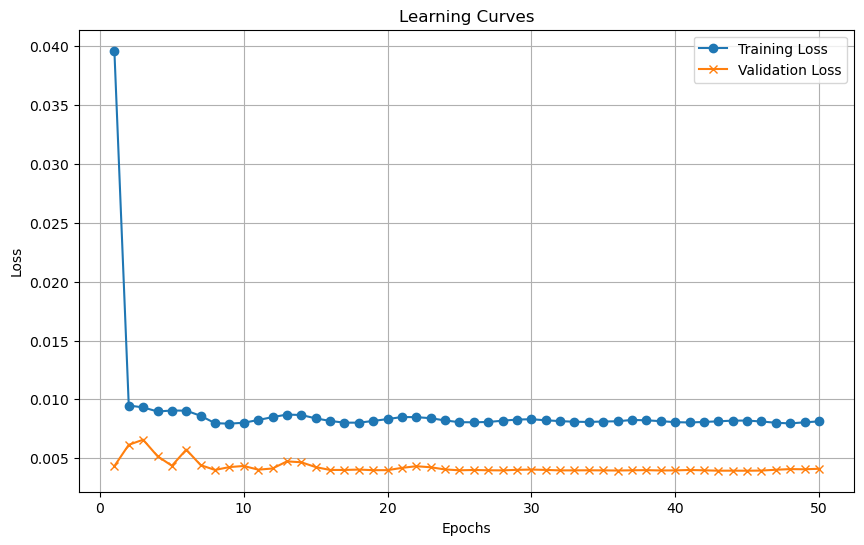

In [4]:
from src.train.trainer import Trainer
from src.train.utils import plot_learning_curves
from src.utils import google_colab_handler

running_in_colab, use_TPU, path, device = google_colab_handler(use_TPU=False, verbose=True)

trainer = Trainer(model=model,
                  device=device,
                  verbose=True,
                  running_in_colab=running_in_colab,
                  use_TPU=use_TPU,
                  use_tensorboard=True)

trainer.train(train_loader=train_loader,
                    val_loader=val_loader,
                    epochs=50,
                    lr=0.001,
                    no_change_patience=100,
                    overfit_patience=100,
                    warmup=10,
                    save_best=True)

plot_learning_curves(trainer.state.train_losses, trainer.state.val_losses)